In [14]:
import pandas_datareader.data as web
import datetime
#from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import predictit
import requests
import pandas as pd 
import io
import numpy as np
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

In [15]:
figsize = (8,5)
fontsize = 10

## Import google trends data and Michigan data 

In [16]:
## google search 
ue_search = pd.read_excel('../Data/UEGoogle.xls')
ue_search.index = ue_search['Month']

ue_search.index = pd.DatetimeIndex(pd.to_datetime(ue_search.index,
                                                  format = '%Y-%m'),
                                  freq='infer')
ue_search.index.name = None

ue_search = ue_search.rename(columns = {'unemployment insurance: (United States)':'Search: \"unemployment insurance\"',
                             'unemployment office: (United States)':'Search: \"unemployment office\"',
                             'file for unemployment: (United States)':'Search: \"file for unemployment\"'})

In [17]:
searches = ['Search: \"unemployment insurance\"',
                'Search: \"unemployment office\"',
                'Search: \"file for unemployment\"']

##########################################################
sub_searches = searches[0:2]
#########################################################

ue_search = ue_search[sub_searches]

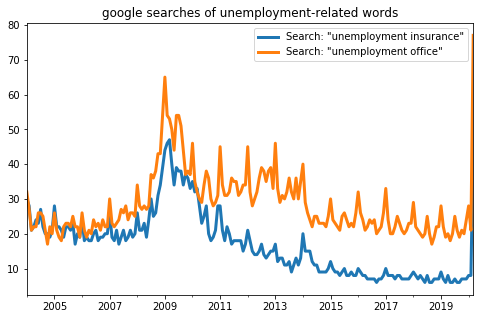

In [18]:
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words')
plt.savefig('figures/search')

In [19]:
## normalize each indicies by its initial value. 

for search in sub_searches:
    ue_search[search] = ue_search[search]*100/ue_search[search][0]

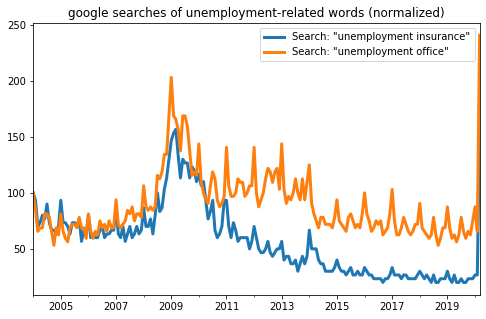

In [20]:
## after normalization
ue_search.plot(lw = 3,
               figsize = figsize,
               title = 'google searches of unemployment-related words (normalized)')
plt.savefig('figures/search_normalized')

In [21]:
## michigan data 
ue_exp = pd.read_excel('../Data/UEExpMichigan.xls',
                       sheet_name = 'Data',
                       index_col = 0)

ue_exp = ue_exp.loc[ue_exp.index.dropna(how='all')]

ue_exp.index = pd.DatetimeIndex(pd.to_datetime(ue_exp.index,
                                               format = '%Y-%m-%d'),
                                  freq = 'infer')
ue_exp.index.name = None

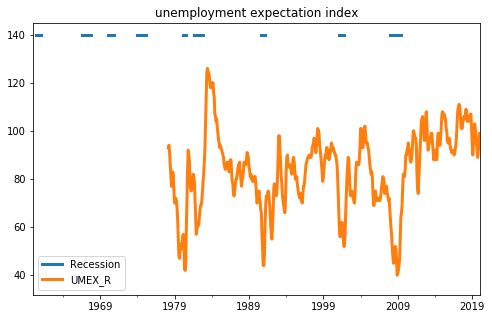

In [22]:
ue_exp.plot(lw = 3,
            figsize = figsize,
           title = 'unemployment expectation index')
plt.savefig('figures/ue_exp_idx')

In [23]:
ue_exp.tail()

,Recession,UMEX_R
2019-09-01,NaN,92.0
2019-10-01,NaN,89.0
2019-11-01,NaN,92.0
2019-12-01,NaN,93.0
2020-01-01,NaN,99.0


## Unemployement rate 

In [24]:
start = datetime.datetime(1960, 1, 30)
end = datetime.datetime(2020, 3, 30)

ue = web.DataReader('UNRATE', 'fred', start, end)

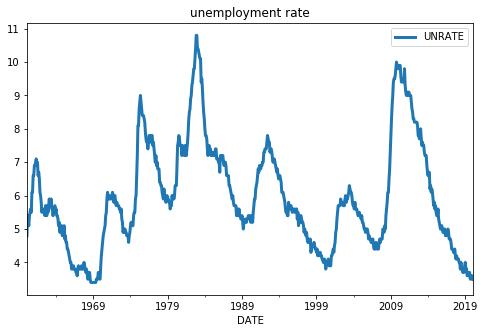

In [25]:
ue.plot(lw = 3,
        figsize = figsize,
        title = 'unemployment rate')
plt.savefig('figures/ue')

In [26]:
ue.index = pd.DatetimeIndex(pd.to_datetime(ue_exp.index,
                                               format = '%Y-%m-%d'),
                                  freq = 'infer')
ue.index.name = None

## Combine 

In [27]:
temp = pd.merge(ue_search,
                ue_exp,
                left_index = True,
                right_index = True,
                how = 'outer'
               )

uedf = pd.merge(temp,
               ue,
               left_index = True,
               right_index = True,
                how = 'outer')

In [28]:
uedf.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment office"',
       'Recession', 'UMEX_R', 'UNRATE'],
      dtype='object')

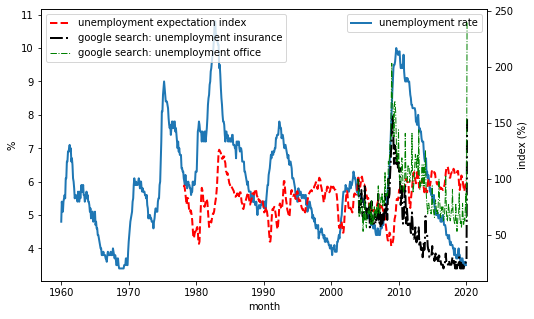

In [29]:
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(uedf.index,uedf['UNRATE'],lw =2, label = 'unemployment rate')
ax2.plot(uedf.index,uedf['UMEX_R'],'r--',lw = 2, label = 'unemployment expectation index')
ax2.plot(uedf.index,uedf['Search: \"unemployment insurance\"'],'k-.',lw = 2, label = 'google search: unemployment insurance')
ax2.plot(uedf.index,uedf['Search: \"unemployment office\"'],'g-.',lw = 1, label = 'google search: unemployment office')
#ax2.plot(uedf.index,uedf['Search: \"file for unemployment\"'],'g-.',lw = 1, label = 'google search: file for unemployment')
ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index (%)',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 2,
          fontsize = fontsize)
plt.savefig('figures/all')

## Regression

### Step 1.  predict michigan index using google search  


\begin{eqnarray}
\underbrace{UEI_{t}}_{\text{Unemployment expectation index}} = \alpha + \sum^3_{k=1}\beta_k \text{Search}_{k,t} + \epsilon_{t}
\end{eqnarray}

- $UEI$: unemployment expectation index
- $Search_{k,t}$: google search index for querry $k$, e.g. "unemployment insurance", "unemployment office", "file for unemployment", etc. Note that since each google search query taken from Google trends is normalized by its own historical peak value, the level of the index can not be directly comparable across different queries. All indicies should be normalized by their initial value at the first period of the sample. 

In [30]:
uedf = uedf.rename(columns = {'UNRATE':'ue',
                              'UMEX_R':'ue_exp_idx'})

In [31]:
vars_reg = sub_searches + ['ue_exp_idx']

uedf_short1 = uedf[vars_reg].dropna(how ='any')

Y = uedf_short1[['ue_exp_idx']]
X = uedf_short1[sub_searches]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             ue_exp_idx   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     82.92
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           1.29e-26
Time:                        10:05:58   Log-Likelihood:                -753.54
No. Observations:                 193   AIC:                             1513.
Df Residuals:                     190   BIC:                             1523.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

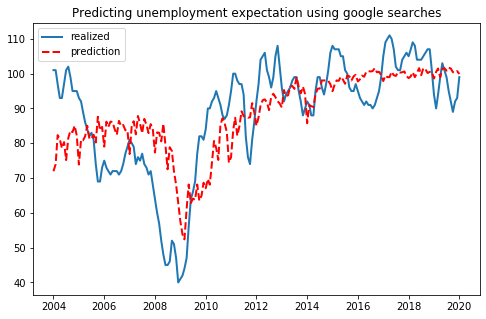

In [32]:
fig = plt.figure(figsize = figsize)
plt.plot(uedf_short1.index,
         uedf_short1['ue_exp_idx'], lw = 2, label = 'realized')
plt.plot(uedf_short1.index,
         results.predict(),'r--',lw = 2,label='prediction')
plt.title('Predicting unemployment expectation using google searches')
plt.legend(loc = 2)
plt.savefig('figures/ue_exp_idx_predict')

In [33]:
print('Estimated coefficients are')
coefs1 = results.params
print(coefs1)

Estimated coefficients are
const                               107.087900
Search: "unemployment insurance"     -0.386940
Search: "unemployment office"         0.035664
dtype: float64


In [34]:
uedf.columns

Index(['Search: "unemployment insurance"', 'Search: "unemployment office"',
       'Recession', 'ue_exp_idx', 'ue'],
      dtype='object')

### Step 2.  predict future realized unemployment rate change using expectations 

\begin{eqnarray}
U_{t+h} - U_{t+h-1} = u + UEI_{t} + \eta_{t+2}
\end{eqnarray}

- $U_{t+h}$: h-month-ahead realized unemployment rate, h = 1 by default. change h to predict for different horizons 
- $UEI_{t}$: unemployment rate expectation index at time $t$ 

In [35]:
uedf['ue_chg'] = uedf['ue'].diff(periods = 1) ## monthly change of unemployment rate 
uedf_short2 = uedf[['ue_chg','ue_exp_idx']].dropna(how ='any')

## # of months lag 
############################################################
h = 1  #by default, next month unemployment rate 
#############################################################

Y = np.array(uedf_short2['ue_chg'][h:])
X = np.array(uedf_short2['ue_exp_idx'][:-h])
X = sm.add_constant(X)
model2 = sm.OLS(Y,X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     110.1
Date:                Sat, 28 Mar 2020   Prob (F-statistic):           1.23e-23
Time:                        10:05:58   Log-Likelihood:                 245.83
No. Observations:                 560   AIC:                            -487.7
Df Residuals:                     558   BIC:                            -479.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3389      0.033     10.143      0.0

In [36]:
coefs2 = results2.params
print('Estimated coefficients are')
coefs2

Estimated coefficients are


array([ 0.33889268, -0.00406059])

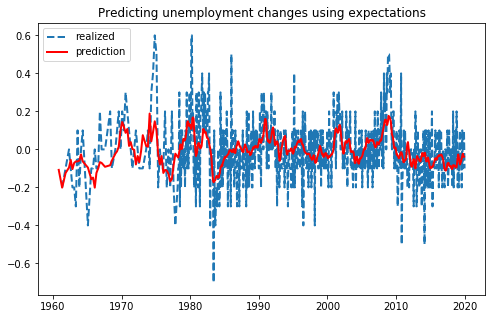

In [37]:
fig = plt.figure(figsize = figsize)
plt.plot(uedf_short2.index[h:],
         np.array(uedf_short2['ue_chg'][h:]), 
         '--',
         lw = 2, 
         label = 'realized')
plt.plot(uedf_short2.index[:-h],
         results2.predict(),
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting unemployment changes using expectations')
plt.legend(loc = 2)
plt.savefig('figures/ue_change_predict')

In [38]:
## 2-step procedure to predict the unemployment rate change in March 2020 and onward

In [39]:
searches = ['Search: \"unemployment insurance\"',
            'Search: \"unemployment office\"',
            'Search: \"file for unemployment\"']

## predict unemployment exp index 
ue_exp_idx_predicted = coefs1[0] + (coefs1[1]*uedf[searches[0]]
                                   + coefs1[2]*uedf[searches[1]]
                                  # + coefs1[3]*uedf[searches[2]]
                                  )

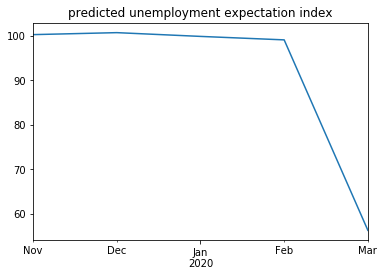

In [40]:
ue_exp_idx_predicted.tail().plot(title = 'predicted unemployment expectation index')
plt.savefig('figures/ue_exp_idx_predict_recent')

In [41]:
## predict unemployment changes 
ue_ch_predicted = coefs2[0] + coefs2[1]*ue_exp_idx_predicted

In [42]:
## change in unemployment rate 

ue_ch_predicted.tail()

2019-11-01   -0.068337
2019-12-01   -0.070147
2020-01-01   -0.066720
2020-02-01   -0.063552
2020-03-01    0.110125
Freq: MS, dtype: float64

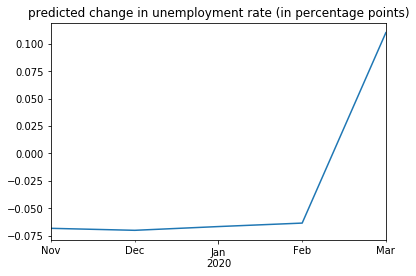

In [43]:
ue_ch_predicted.tail().plot(title = 'predicted change in unemployment rate (in percentage points)')
plt.savefig('figures/ue_change_predict_recent')